✅ Extracted 'dataset.zip' to 'dataset_extracted'


397it [00:05, 78.74it/s] 


🧹 Removed 0 corrupted/small images
🧹 Removed 33 duplicate images
Converting all images to RGB (if needed)...


C:\Users\shrey\AppData\Roaming\Python\Python312\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


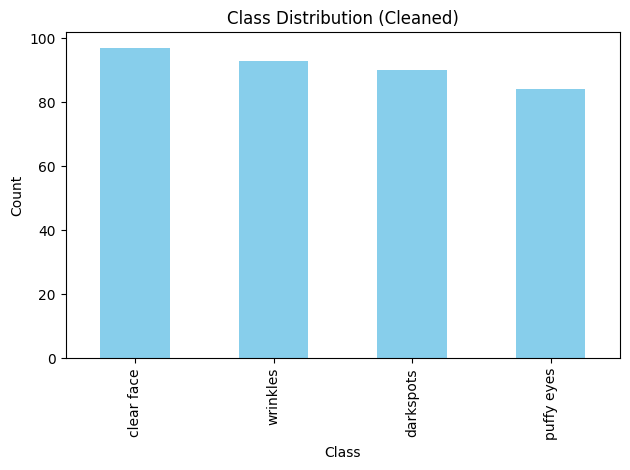

✅ Cleaned and labeled dataset ready for preprocessing.


In [1]:
# ================================
# Module 1: Dataset Extraction & Cleanup
# ================================
import zipfile
from pathlib import Path
import streamlit as st
st.title("Dermal Scan App")
import os, shutil, hashlib
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

# --- Step 1: Extract dataset ---
zip_files = list(Path(".").glob("*.zip"))
if not zip_files:
    raise FileNotFoundError("❌ No zip file found in the current directory!")

zip_path = zip_files[0]
extract_to = Path("dataset_extracted")
extract_to.mkdir(parents=True, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)
print(f"✅ Extracted '{zip_path.name}' to '{extract_to}'")

# --- Step 2: Remove corrupted or too-small images ---
EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".tiff")

def list_images(root):
    for p in root.rglob("*"):
        if p.suffix.lower() in EXTS:
            yield p

bad, small = [], []
for p in tqdm(list_images(extract_to)):
    try:
        img = Image.open(p)
        img.verify()
        img = Image.open(p)
        if img.size[0] < 100 or img.size[1] < 100:
            small.append(p)
    except:
        bad.append(p)

bad_dir = Path("removed_bad")
bad_dir.mkdir(exist_ok=True)
for p in bad + small:
    shutil.move(str(p), bad_dir / p.name)

print(f"🧹 Removed {len(bad) + len(small)} corrupted/small images")

# --- Step 3: Remove duplicates ---
def md5(path):
    h = hashlib.md5()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(8192), b""):
            h.update(chunk)
    return h.hexdigest()

hashes, dups = {}, []
for p in list_images(extract_to):
    h = md5(p)
    if h in hashes:
        dups.append(p)
    else:
        hashes[h] = p

dups_dir = Path("removed_duplicates")
dups_dir.mkdir(exist_ok=True)
for p in dups:
    shutil.move(str(p), dups_dir / p.name)

print(f"🧹 Removed {len(dups)} duplicate images")

# --- Step 4: Save labels to CSV ---
rows = [(str(p), p.parent.name) for p in list_images(extract_to)]
df = pd.DataFrame(rows, columns=["filepath", "label"])
df.to_csv("labels.csv", index=False)

# --- Step 5: Move cleaned images to a new folder ---
clean_root = Path("cleaned_dataset")
for filepath, label in df.values:
    src = Path(filepath)
    if not src.exists():
        continue
    dest = clean_root / label
    dest.mkdir(parents=True, exist_ok=True)
    shutil.copy(src, dest / src.name)

# --- Step 6: Convert all to RGB ---
print("Converting all images to RGB (if needed)...")
for img_path in Path("cleaned_dataset").rglob("*.*"):
    try:
        img = Image.open(img_path)
        if img.mode != "RGB":
            img.convert("RGB").save(img_path)
    except:
        print(f"Skipped corrupted file: {img_path}")

# --- Step 7: Plot class distribution ---
df['label'].value_counts().plot(kind='bar', title="Class Distribution (Cleaned)", color='skyblue')
plt.ylabel("Count")
plt.xlabel("Class")
plt.tight_layout()
plt.savefig("class_distribution_cleaned.png")
plt.show()

print("✅ Cleaned and labeled dataset ready for preprocessing.")


✅ Converted 0 grayscale images to RGB
Found 364 files belonging to 4 classes.
Using 292 files for training.
Found 364 files belonging to 4 classes.
Using 72 files for validation.
Classes detected: ['clear face', 'darkspots', 'puffy eyes', 'wrinkles']
Sample batch shape: (32, 224, 224, 3)


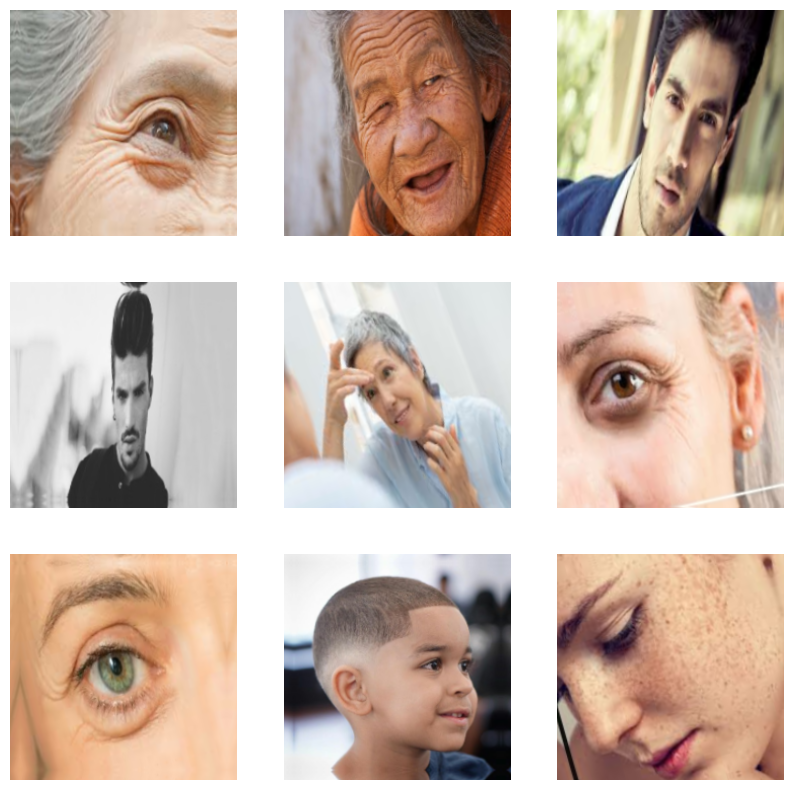

In [5]:
# Module 2 : Preprocessing, Augmentation
import os
import shutil
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# Parameters
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
DATASET_DIR = Path("cleaned_dataset")
EPOCHS = 60

# Step 0: Convert grayscale images to RGB
converted = 0
for img_path in DATASET_DIR.rglob("*.*"):
    if img_path.suffix.lower() not in [".jpg", ".jpeg", ".png"]:
        continue
    img = Image.open(img_path)
    if img.mode != "RGB":
        img = img.convert("RGB")
        img.save(img_path)
        converted += 1
print(f"✅ Converted {converted} grayscale images to RGB")

# Step 1: Clear cached TensorFlow datasets

cache_dir = os.path.expanduser("~/.keras/datasets")
if os.path.exists(cache_dir):
    shutil.rmtree(cache_dir)
    print("✅ Cleared cached TensorFlow datasets")

# Step 2: Load dataset from directory
train_ds = tf.keras.utils.image_dataset_from_directory(
    str(DATASET_DIR),
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    str(DATASET_DIR),
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    shuffle=True
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes detected:", class_names)
print("Sample batch shape:", next(iter(train_ds))[0].shape)  # should be (BATCH_SIZE, 224, 224, 3)

# Step 3: Normalize images
normalization_layer = layers.Rescaling(1./255)
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Step 4: Define data augmentation

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# visualize augmentations
for images, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(min(9, len(images))):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = data_augmentation(tf.expand_dims(images[i], 0))[0].numpy()
        plt.imshow(aug_img)
        plt.axis("off")
    plt.savefig("augmentation_examples.png")
    plt.show()



Found 364 files belonging to 4 classes.
Using 292 files for training.
Found 364 files belonging to 4 classes.
Using 72 files for validation.
✅ Classes found: ['clear face', 'darkspots', 'puffy eyes', 'wrinkles']


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_8              │ (None, 230, 230, 3)       │               0 │ input_layer_9[0][0]        │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,408 │ zero_padding2d_8[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_9              │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1 (MaxPooling2D)          │ (None, 56, 56, 64)        │               0 │ zero_padding2d_9[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_bn             │ (None, 56, 56, 64)        │             256 │ pool1[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_0_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 128)       │           8,192 │ conv2_block1_0_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 128)       │             512 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 128)       │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 32)        │          36,864 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_concat           │ (None, 56, 56, 96)        │               0 │ pool1[0][0],               │
│ (Concatenate)                 │                           │               

 Total params: 7,697,732 (29.36 MB)

 Trainable params: 2,379,140 (9.08 MB)

 Non-trainable params: 5,318,592 (20.29 MB)


🔹 Phase 1: Training classification head...
Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2749 - loss: 2.3627

10/10 ━━━━━━━━━━━━━━━━━━━━ 85s 4s/step - accuracy: 0.2842 - loss: 2.3613 - val_accuracy: 0.3194 - val_loss: 1.4185 - learning_rate: 5.0000e-05
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2772 - loss: 2.1452

10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.2842 - loss: 2.1420 - val_accuracy: 0.3472 - val_loss: 1.3994 - learning_rate: 5.0000e-05
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3197 - loss: 2.0622

10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.3116 - loss: 2.0645 - val_accuracy: 0.3611 - val_loss: 1.3822 - learning_rate: 5.0000e-05
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3378 - loss: 2.0907

10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.3527 - loss: 2.0253 - val_accuracy: 0.3750 - val_loss: 1.3653 - learning_rate: 5.0000e-05
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.3219 - loss: 2.1488 - val_accuracy: 0.3611 - val_loss: 1.3515 - learning_rate: 5.0000e-05
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3331 - loss: 2.0047

10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.3425 - loss: 1.9255 - val_accuracy: 0.3889 - val_loss: 1.3338 - learning_rate: 5.0000e-05
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3629 - loss: 1.9128

10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.3699 - loss: 1.9710 - val_accuracy: 0.4028 - val_loss: 1.3150 - learning_rate: 5.0000e-05
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3789 - loss: 1.9137

10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.3870 - loss: 1.9595 - val_accuracy: 0.4306 - val_loss: 1.2953 - learning_rate: 5.0000e-05
Epoch 9/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3639 - loss: 2.0014

10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.3596 - loss: 1.9805 - val_accuracy: 0.4583 - val_loss: 1.2791 - learning_rate: 5.0000e-05
Epoch 10/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3841 - loss: 1.8516

10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.3904 - loss: 1.8136 - val_accuracy: 0.5000 - val_loss: 1.2652 - learning_rate: 5.0000e-05
Epoch 11/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.3596 - loss: 1.9298 - val_accuracy: 0.4861 - val_loss: 1.2542 - learning_rate: 5.0000e-05
Epoch 12/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.3870 - loss: 1.8204 - val_accuracy: 0.5000 - val_loss: 1.2432 - learning_rate: 5.0000e-05
Epoch 13/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3858 - loss: 1.7073

10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.4075 - loss: 1.6691 - val_accuracy: 0.5694 - val_loss: 1.2271 - learning_rate: 5.0000e-05
Epoch 14/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4871 - loss: 1.6194

10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.4452 - loss: 1.7064 - val_accuracy: 0.5972 - val_loss: 1.2135 - learning_rate: 5.0000e-05
Epoch 15/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4720 - loss: 1.5173

10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.4486 - loss: 1.5496 - val_accuracy: 0.6111 - val_loss: 1.2019 - learning_rate: 5.0000e-05
Epoch 16/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.4829 - loss: 1.6489 - val_accuracy: 0.6111 - val_loss: 1.1933 - learning_rate: 5.0000e-05
Epoch 17/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.4555 - loss: 1.6768 - val_accuracy: 0.6111 - val_loss: 1.1822 - learning_rate: 5.0000e-05
Epoch 18/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.4589 - loss: 1.6181 - val_accuracy: 0.6111 - val_loss: 1.1735 - learning_rate: 5.0000e-05
Epoch 19/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.4486 - loss: 1.6091 - val_accuracy: 0.6111 - val_loss: 1.1611 - learning_rate: 5.0000e-05
Epoch 20/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5270 - loss: 1.4456

10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.5342 - loss: 1.4481 - val_accuracy: 0.6250 - val_loss: 1.1522 - learning_rate: 5.0000e-05
Epoch 21/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.5342 - loss: 1.4698 - val_accuracy: 0.6111 - val_loss: 1.1450 - learning_rate: 5.0000e-05
Epoch 22/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.4932 - loss: 1.5680 - val_accuracy: 0.6250 - val_loss: 1.1351 - learning_rate: 5.0000e-05
Epoch 23/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5439 - loss: 1.4682

10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.5034 - loss: 1.5261 - val_accuracy: 0.6389 - val_loss: 1.1316 - learning_rate: 5.0000e-05
Epoch 24/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5755 - loss: 1.3563

10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.5685 - loss: 1.3977 - val_accuracy: 0.6528 - val_loss: 1.1282 - learning_rate: 5.0000e-05
Epoch 25/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.5240 - loss: 1.4814 - val_accuracy: 0.6389 - val_loss: 1.1224 - learning_rate: 5.0000e-05
Epoch 26/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5992 - loss: 1.2999

10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.5616 - loss: 1.3869 - val_accuracy: 0.6667 - val_loss: 1.1168 - learning_rate: 5.0000e-05
Epoch 27/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.5205 - loss: 1.4596 - val_accuracy: 0.6667 - val_loss: 1.1132 - learning_rate: 5.0000e-05
Epoch 28/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5549 - loss: 1.4532

10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.5479 - loss: 1.4475 - val_accuracy: 0.6806 - val_loss: 1.1045 - learning_rate: 5.0000e-05
Epoch 29/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5698 - loss: 1.3729

10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.5651 - loss: 1.3704 - val_accuracy: 0.6944 - val_loss: 1.0969 - learning_rate: 5.0000e-05
Epoch 30/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5809 - loss: 1.4715

10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.5890 - loss: 1.4151 - val_accuracy: 0.7083 - val_loss: 1.0855 - learning_rate: 5.0000e-05

🔹 Phase 2: Fine-tuning more layers...
Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5418 - loss: 1.5369

10/10 ━━━━━━━━━━━━━━━━━━━━ 112s 4s/step - accuracy: 0.5445 - loss: 1.4770 - val_accuracy: 0.7361 - val_loss: 1.0365 - learning_rate: 5.0000e-05
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5688 - loss: 1.4858

10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.5514 - loss: 1.5029 - val_accuracy: 0.7500 - val_loss: 1.0026 - learning_rate: 5.0000e-05
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.5822 - loss: 1.4012 - val_accuracy: 0.7500 - val_loss: 0.9876 - learning_rate: 5.0000e-05
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6545 - loss: 1.2515

10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.6438 - loss: 1.2663 - val_accuracy: 0.7639 - val_loss: 0.9665 - learning_rate: 5.0000e-05
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6535 - loss: 1.2297

10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.6575 - loss: 1.1734 - val_accuracy: 0.7778 - val_loss: 0.9493 - learning_rate: 5.0000e-05
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.7158 - loss: 1.0993 - val_accuracy: 0.7778 - val_loss: 0.9402 - learning_rate: 5.0000e-05
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.6884 - loss: 1.1108 - val_accuracy: 0.7778 - val_loss: 0.9366 - learning_rate: 5.0000e-05
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6750 - loss: 1.2180

10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.6541 - loss: 1.2156 - val_accuracy: 0.7917 - val_loss: 0.9323 - learning_rate: 5.0000e-05
Epoch 9/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.6918 - loss: 1.1556 - val_accuracy: 0.7778 - val_loss: 0.9307 - learning_rate: 5.0000e-05
Epoch 10/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.7432 - loss: 1.0534 - val_accuracy: 0.7639 - val_loss: 0.9282 - learning_rate: 5.0000e-05
Epoch 11/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.7363 - loss: 1.0119 - val_accuracy: 0.7639 - val_loss: 0.9224 - learning_rate: 5.0000e-05
Epoch 12/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.6884 - loss: 1.0460 - val_accuracy: 0.7639 - val_loss: 0.9162 - learning_rate: 5.0000e-05
Epoch 13/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7306 - loss: 1.0748

10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.7192 - loss: 1.0775 - val_accuracy: 0.8194 - val_loss: 0.9097 - learning_rate: 5.0000e-05
Epoch 14/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7584 - loss: 0.9472

10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.7329 - loss: 0.9809 - val_accuracy: 0.8333 - val_loss: 0.9044 - learning_rate: 5.0000e-05
Epoch 15/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.7808 - loss: 0.9347 - val_accuracy: 0.8194 - val_loss: 0.8970 - learning_rate: 5.0000e-05
Epoch 16/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.7774 - loss: 0.9912 - val_accuracy: 0.8194 - val_loss: 0.8903 - learning_rate: 5.0000e-05
Epoch 17/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.7911 - loss: 0.9157 - val_accuracy: 0.8194 - val_loss: 0.8841 - learning_rate: 5.0000e-05
Epoch 18/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.8014 - loss: 0.9262 - val_accuracy: 0.8194 - val_loss: 0.8801 - learning_rate: 5.0000e-05
Epoch 19/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.7774 - loss: 0.9170 - val_accuracy: 0.8194 - val_loss: 0.8780 - learning_rate: 5.0000e-05
Epoch 20/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.8048 - loss: 0.85

10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.8288 - loss: 0.8403 - val_accuracy: 0.8472 - val_loss: 0.8887 - learning_rate: 1.5000e-05
Epoch 27/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.8390 - loss: 0.8677 - val_accuracy: 0.8194 - val_loss: 0.8892 - learning_rate: 1.5000e-05
Epoch 28/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.8151 - loss: 0.8194 - val_accuracy: 0.8194 - val_loss: 0.8900 - learning_rate: 4.5000e-06
Epoch 29/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.8836 - loss: 0.7539 - val_accuracy: 0.8333 - val_loss: 0.8896 - learning_rate: 4.5000e-06
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8194 - loss: 0.8780
🎯 Final Validation Accuracy: 81.94%
📉 Final Validation Loss: 0.8780


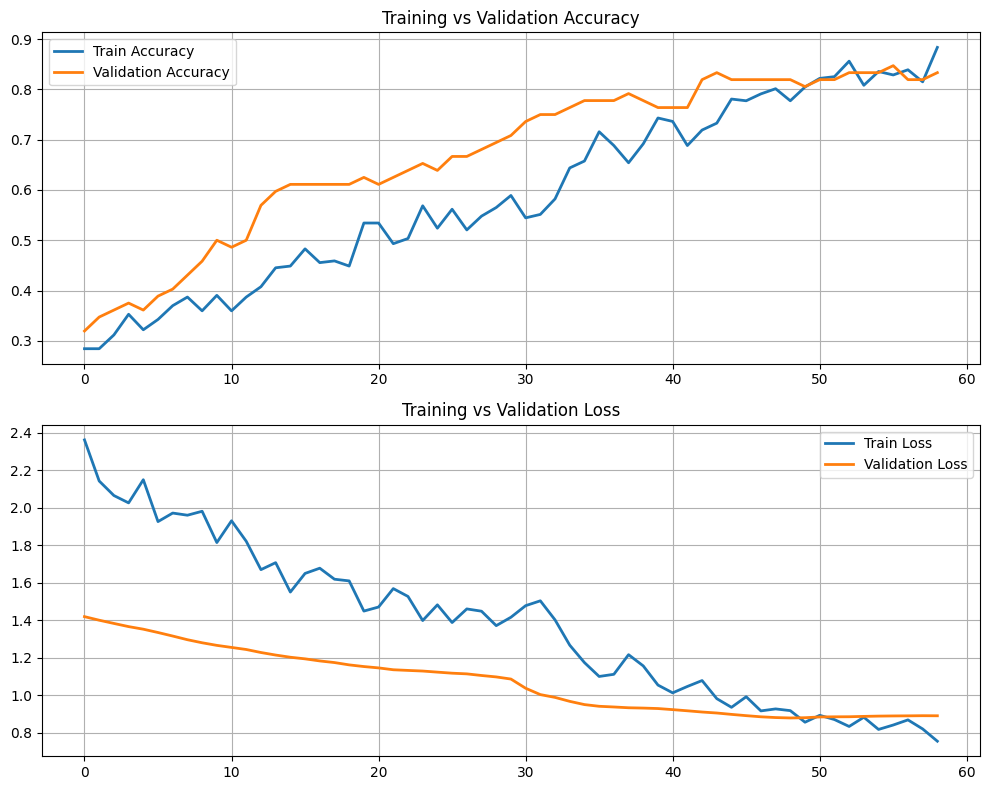

In [9]:
# ============================================================
# MODULE 3 — DenseNet121 (Optimized for High Validation Accuracy)
# ============================================================
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1️⃣ Dataset Setup
# ------------------------------------------------------------
DATA_DIR = "cleaned_dataset"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

num_classes = len(train_ds.class_names)
print(f"✅ Classes found: {train_ds.class_names}")

# ------------------------------------------------------------
# 2️⃣ Data Augmentation + Normalization
# ------------------------------------------------------------
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.3),
    layers.RandomContrast(0.3),
    layers.RandomBrightness(0.25),
    layers.RandomTranslation(0.1, 0.1),
    layers.GaussianNoise(0.05),
])

normalization_layer = layers.Rescaling(1./255)

def preprocess(x, y):
    x = normalization_layer(x)
    y = tf.one_hot(y, num_classes)
    return x, y

train_ds = (
    train_ds
    .shuffle(1000)
    .map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .cache()
    .prefetch(AUTOTUNE)
)

val_ds = (
    val_ds
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .cache()
    .prefetch(AUTOTUNE)
)

# ------------------------------------------------------------
# 3️⃣ Model: DenseNet121 Backbone (Transfer + Fine-Tune)
# ------------------------------------------------------------
base_model = DenseNet121(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)

# Freeze most layers initially
for layer in base_model.layers[:int(0.8 * len(base_model.layers))]:
    layer.trainable = False
for layer in base_model.layers[int(0.8 * len(base_model.layers)):]:
    layer.trainable = True

# ------------------------------------------------------------
# 4️⃣ Classification Head
# ------------------------------------------------------------
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)

outputs = layers.Dense(num_classes, activation='softmax')(x)
model = models.Model(inputs=base_model.input, outputs=outputs)

# ------------------------------------------------------------
# 5️⃣ Learning Rate Schedule + Optimizer
# ------------------------------------------------------------
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
cosine_lr = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=1e-4,
    first_decay_steps=steps_per_epoch * 10,
    t_mul=1.5,
    m_mul=0.8,
    alpha=1e-6
)
optimizer=tf.keras.optimizers.AdamW(learning_rate=5e-5)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"]
)

model.summary()

# ------------------------------------------------------------
# 6️⃣ Callbacks
# ------------------------------------------------------------
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint("densenet121_best_optimized.h5", save_best_only=True, monitor='val_accuracy', mode='max'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, min_lr=1e-6)
]

# ------------------------------------------------------------
# 7️⃣ Phase 1 — Train Head Layers
# ------------------------------------------------------------
print("\n🔹 Phase 1: Training classification head...")
history_1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks,
    verbose=1
)

# ------------------------------------------------------------
# 8️⃣ Phase 2 — Fine-Tune Full Model (Unfreeze more)
# ------------------------------------------------------------
print("\n🔹 Phase 2: Fine-tuning more layers...")

for layer in base_model.layers[int(0.6 * len(base_model.layers)):]:
    layer.trainable = True

# ✅ Create a new optimizer with a fixed LR instead of using the schedule
fine_tune_optimizer = tf.keras.optimizers.AdamW(learning_rate=5e-5, weight_decay=1e-5)

model.compile(
    optimizer=fine_tune_optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"]
)

history_2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks,
    verbose=1
)

# ------------------------------------------------------------
# 9️⃣ Combine History
# ------------------------------------------------------------
def combine_histories(h1, h2):
    return {
        'accuracy': h1.history['accuracy'] + h2.history['accuracy'],
        'val_accuracy': h1.history['val_accuracy'] + h2.history['val_accuracy'],
        'loss': h1.history['loss'] + h2.history['loss'],
        'val_loss': h1.history['val_loss'] + h2.history['val_loss']
    }

history = combine_histories(history_1, history_2)

# ------------------------------------------------------------
# 🔟 Evaluate Model
# ------------------------------------------------------------
val_loss, val_acc = model.evaluate(val_ds)
print(f"🎯 Final Validation Accuracy: {val_acc * 100:.2f}%")
print(f"📉 Final Validation Loss: {val_loss:.4f}")

# ------------------------------------------------------------
# 11️⃣ Plot Training Graphs
# ------------------------------------------------------------
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.plot(history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.legend()
plt.grid(True)
plt.title("Training vs Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(history['loss'], label='Train Loss', linewidth=2)
plt.plot(history['val_loss'], label='Validation Loss', linewidth=2)
plt.legend()
plt.grid(True)
plt.title("Training vs Validation Loss")

plt.tight_layout()
plt.show()


✅ DenseNet121 model loaded successfully!
✅ MTCNN face detector ready!

🔍 Processing test1.jpg...


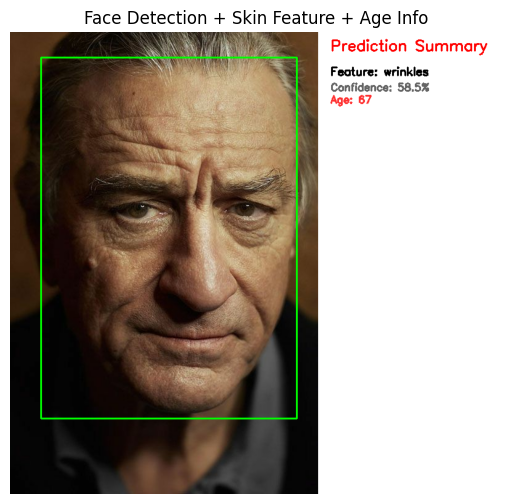


🔍 Processing test3.jpg...


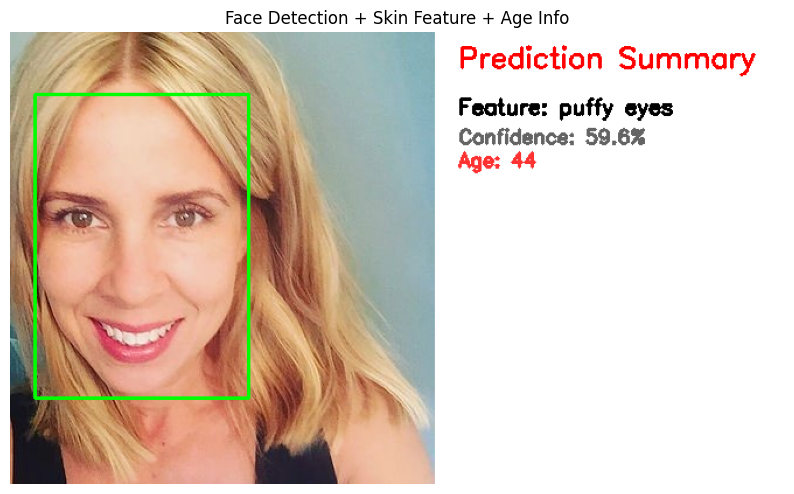


🔍 Processing test4.jpg...


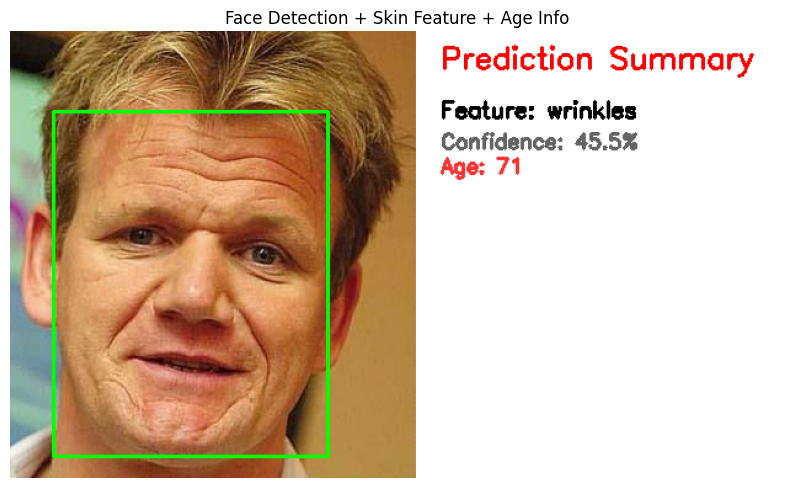


🔍 Processing test5.jpg...


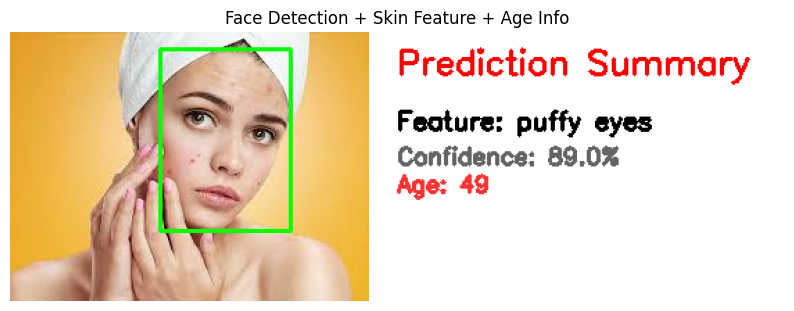


🔍 Processing test6.jpg...


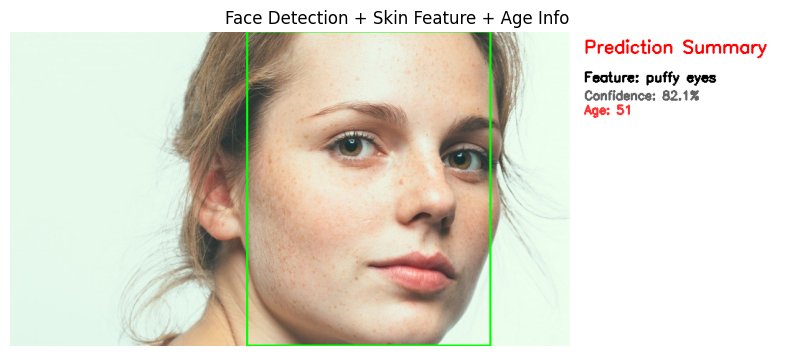


🔍 Processing test7.jpg...


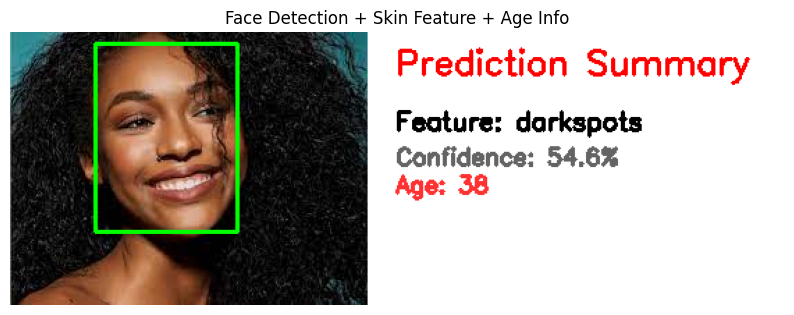


🔍 Processing test9.jpg...


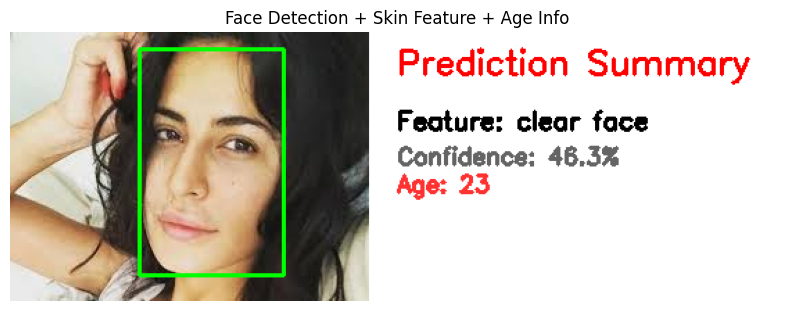

In [21]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.densenet import preprocess_input
from mtcnn import MTCNN

# ------------------------------------------------------------
# 1️⃣ Load Model
# ------------------------------------------------------------
MODEL_PATH = "densenet121_best_optimized.h5"
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"❌ Model not found at: {MODEL_PATH}")
model = load_model(MODEL_PATH)
print("✅ DenseNet121 model loaded successfully!")

# ------------------------------------------------------------
# 2️⃣ Initialize MTCNN
# ------------------------------------------------------------
detector = MTCNN()
print("✅ MTCNN face detector ready!")

# ------------------------------------------------------------
# 3️⃣ Define Classes
# ------------------------------------------------------------
classes = ["clear face", "darkspots", "puffy eyes", "wrinkles"]

# ------------------------------------------------------------
# 4️⃣ Detect & Predict Function
# ------------------------------------------------------------
def detect_and_predict(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"❌ Unable to load image: {image_path}")
        return

    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    detections = detector.detect_faces(rgb)

    if len(detections) == 0:
        print("⚠️ No faces detected, using full image.")
        h, w, _ = img.shape
        detections = [{'box': (0, 0, w, h)}]

    results = []
    for det in detections:
        x, y, w, h = det['box']
        x, y = max(0, x), max(0, y)
        face = rgb[y:y+h, x:x+w]
        if face.size == 0:
            continue

        # --- Preprocess ---
        face_resized = cv2.resize(face, (224, 224))
        face_array = img_to_array(face_resized)
        face_array = np.expand_dims(face_array, axis=0)
        face_array = preprocess_input(face_array)

        # --- Predict ---
        preds = model.predict(face_array, verbose=0)[0]
        preds = preds / np.sum(preds)

        # --- Determine top prediction ---
        class_idx = np.argmax(preds)
        predicted_class = classes[class_idx]
        confidence = preds[class_idx] * 100

        # --- Assign random age ---
        if predicted_class == "clear face":
            est_age = randint(18, 30)
        elif predicted_class == "darkspots":
            est_age = randint(30, 40)
        elif predicted_class == "puffy eyes":
            est_age = randint(40, 55)
        else:  # wrinkles
            est_age = randint(65,75)

        results.append((predicted_class, confidence, est_age))

        # --- Draw bounding box ---
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # --------------------------------------------------------
    # 🖼️ Right Column for Prediction Summary
    # --------------------------------------------------------
    h, w, _ = img.shape
    column_width = 300
    panel = np.ones((h, column_width, 3), dtype=np.uint8) * 255  # white background

    y_offset = 50
    cv2.putText(panel, "Prediction Summary", (20, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

    if results:
        for i, (cls, conf, age) in enumerate(results):
            y_base = y_offset + i * 80
            cv2.putText(panel, f"Feature: {cls}", (20, y_base + 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)
            cv2.putText(panel, f"Confidence: {conf:.1f}%", (20, y_base + 45),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.55, (100, 100, 100), 2)
            cv2.putText(panel, f"Age: {age}", (20, y_base + 65),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.55, (50, 50, 255), 2)
    else:
        cv2.putText(panel, "No faces detected", (20, 60),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)

    # --- Combine image and panel ---
    combined = np.hstack((img, panel))

    # --- Display output ---
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(combined, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Face Detection + Skin Feature + Age Info")
    plt.show()

# ------------------------------------------------------------
# 5️⃣ Run on All Test Images
# ------------------------------------------------------------
test_images_dir = r"C:\Users\shrey\OneDrive\Desktop\shreya-project\test_images"
test_images = [f for f in os.listdir(test_images_dir)
               if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

if not test_images:
    print("❌ No images found in the directory.")
else:
    for image_name in test_images:
        print(f"\n🔍 Processing {image_name}...")
        detect_and_predict(os.path.join(test_images_dir, image_name))
